# The transient Universe

Time-domain astronomy is one of the new frontiers. Example of transient phenomena include:

1. Tidal distruption events. [Stars shouldn't go near supermassive black holes, it's dangerous!]
![Tidal_Disruption_Events.png](Tidal_Disruption_Events.png)
2. Sudden flares of active galactic nuclei
![EM_Counterpart.png](EM_Counterpart.png)
3. Supernovae
![Thermonuclear_SN.png](Thermonuclear_SN.png)

## Part 1

**Tasks**

**Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!**

1. Read in solutions/transient.npy. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2. One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as: 

    $y = b$, for $t < t_0$ 

    $y = b + A \exp{[-\alpha (t - t_0)]}$, for $t \geq t_0$ 

    where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

    Code this burst model, and code a likelihood function for this data with the burst model. 

    Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.

3. Using one of the MCMC sampler that we looked at in class (emcee, pymc), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of ${b, \ A, \ t_0, \ \alpha}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them 
    - $b \in \rm Uniform[0, 50]$
    - $A \in \rm Uniform[0, 50]$
    - $t_0 \in \rm Uniform[0, 100]$
    - $\ln(\alpha) \in \rm Uniform[-5, 5]$ (careful: uniform in $\ln(\alpha)$, not $\alpha$).

4. Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5. Make a corner plot of the 4-D parameter space, with labels, $[68, 95] %$ credible levels and quantiles, and titles.

6. Now choose 100 samples randomly from your burned, thinned chain and plot the 100 corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these 100 burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7. For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0 = X_{-Z}^{+Y}$


In [445]:
import numpy as np
import matplotlib.pyplot as plt
import astroML.stats as astroMLstats
import emcee
import corner

from astropy.visualization import hist
from scipy import stats
from scipy import integrate
from scipy.stats import norm
from scipy.stats import uniform
from IPython.display import display, Math

In [446]:
def model(t, b, A, alpha, t_0):
    return np.where(t < t_0, b, b + A * np.exp(-alpha * (t - t_0)))
    
def log_prior(params, bounds):
    b, A, alpha, t_0 = params
    if (bounds[0][0] < b < bounds[0][1] and
        bounds[1][0] < A < bounds[1][1] and
        np.exp(bounds[2][0]) < alpha < np.exp(bounds[2][1]) and
        bounds[3][0] < t_0 < bounds[3][1]):
        return 0.0  # log(1)
    else:
        return -np.inf

def log_likelihood(params, t, data, err):
    b, A, alpha, t_0 = params
    model_flux = model(t, b, A, alpha, t_0)
    return -0.5 * np.sum(((data - model_flux) / err)**2 + np.log(2 * np.pi * err**2))

def log_posterior(params, t, data, err, bounds):
    lp = log_prior(params, bounds)
    if not np.isfinite(lp):
        return lp
    else:
        return lp + log_likelihood(params, t, data, err)

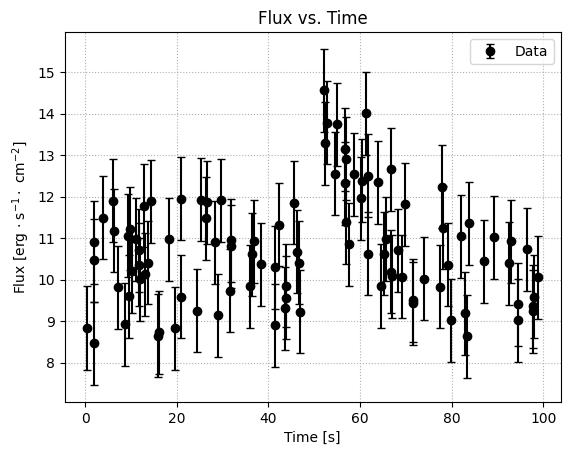

In [ ]:
# Import data
data = np.load('transient.npy', allow_pickle=True)

t = data[:, 0]
flux = data[:, 1]
err_flux = data[:, 2]

# Plot data
plt.errorbar(t, flux, err_flux, fmt='o', color='black', capsize=3, label = 'Data')
plt.title('Flux vs. Time')
plt.xlabel('Time [s]')
plt.ylabel('Flux [erg $\cdot$ s$^{-1} \cdot$ cm$^{-2}$]')
plt.legend()
plt.grid(linestyle=':')
plt.show()

### MCMC

In [448]:
# Limits of parameters distribution
# N.B.: The order of the parameter is: b, A, ln(alpha), t_0
bounds = [[0, 50], [0, 50], [-5, 5], [0, 100]]

ndim = 4  # number of parameters in the model
nwalkers = 20  # number of MCMC walkers
nsteps = 10000  # number of MCMC steps to take **for each walker**

np.random.seed(0)

# Starting guess for each parameter
starting_guesses = np.array([10, 5, 1e-1, 50]) + 1e-2 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(t, flux, err_flux, bounds))
sampler.run_mcmc(starting_guesses, nsteps, progress=True)

100%|██████████| 10000/10000 [00:10<00:00, 995.66it/s]


State([[10.38980025  3.6744875   0.1112175  51.78148255]
 [10.10814388  3.31836115  0.0651418  48.32467955]
 [10.42810817  6.92656516  0.12382564 47.7735836 ]
 [10.29407254  5.6007261   0.09030436 47.54433479]
 [10.33870514  7.25806954  0.17433849 49.40582679]
 [10.35758503  4.77573152  0.12367438 49.67834948]
 [10.2955387   4.13354064  0.11686435 50.46611204]
 [10.47853425  4.21733071  0.11033894 49.78855569]
 [10.38540419  5.17087139  0.13411024 50.72998008]
 [10.49717153  4.03726152  0.14654133 50.75448449]
 [10.23439611  5.2728455   0.10464919 48.21277532]
 [10.24151177  4.84734901  0.14191681 49.97814306]
 [10.16805027  8.07698674  0.12146833 47.41213398]
 [10.30045185  7.02718119  0.13623095 48.05823292]
 [10.31753292  5.03568393  0.14094362 50.88066927]
 [ 9.98527589  5.91450862  0.1212136  51.45934925]
 [10.34631626  9.1974327   0.14948869 47.84072295]
 [10.21261381  5.42790325  0.13069283 49.95019082]
 [10.46573371  4.56279523  0.15127298 51.34656371]
 [10.36505762  3.89320759

#### Trace plot and autocorrelation time

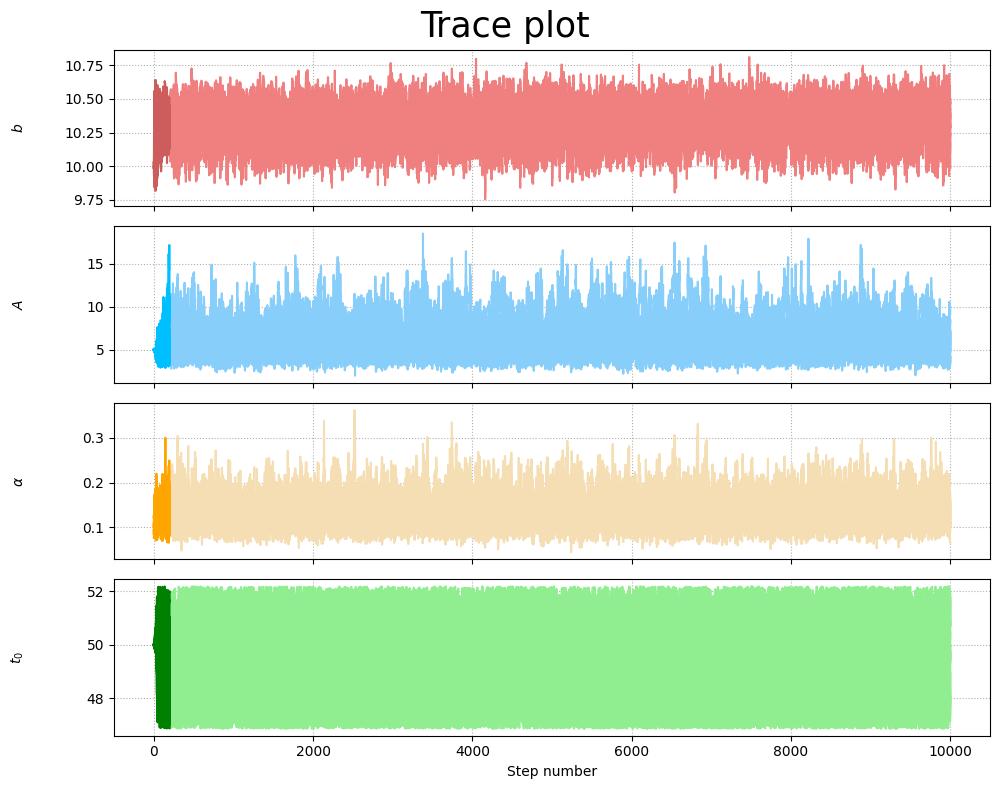

In [449]:
# Trace plot
chain = sampler.get_chain() # sampler.chain is of shape (nwalkers, nsteps, ndim)

labels = [r'$b$', r'$A$', r'$\alpha$', r'$t_0$']
steps = np.linspace(0, nsteps, nsteps)
colors = ['lightcoral', 'lightskyblue', 'wheat', 'lightgreen']
dark_colors = ['indianred', 'deepskyblue', 'orange', 'green']

burns = [200, 200, 200, 200]

fig, axes = plt.subplots(ndim, figsize=(10, 8), sharex=True)

for i in range(0, ndim):
    ax = axes[i]
    burn = burns[i]
    color = colors[i]
    dark_color = dark_colors[i]

    ax.plot(steps[burn:], chain[burn:, :, i], c=color)
    ax.plot(steps[:burn], chain[:burn, :, i], c=dark_color, label="Burn-in")

    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    #ax.set_xlim(0, 1000)
    ax.grid(linestyle=":")

axes[-1].set_xlabel("Step number")
fig.suptitle("Trace plot", fontsize=25)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


In [450]:
taus = sampler.get_autocorr_time()
burn = np.max(burns)
thin = int(np.max(taus)) + 1

# Remove the autocorreleted samples
samples = sampler.get_chain(discard=burn, thin=thin, flat=True)

print(f'Original chain: {sampler.chain.shape}')
print(f'Burn-in: {burn}, Thin: {thin}')
print(f'Shape after thinning: {samples.shape}')

Original chain: (20, 10000, 4)
Burn-in: 200, Thin: 72
Shape after thinning: (2720, 4)


#### Corner plot

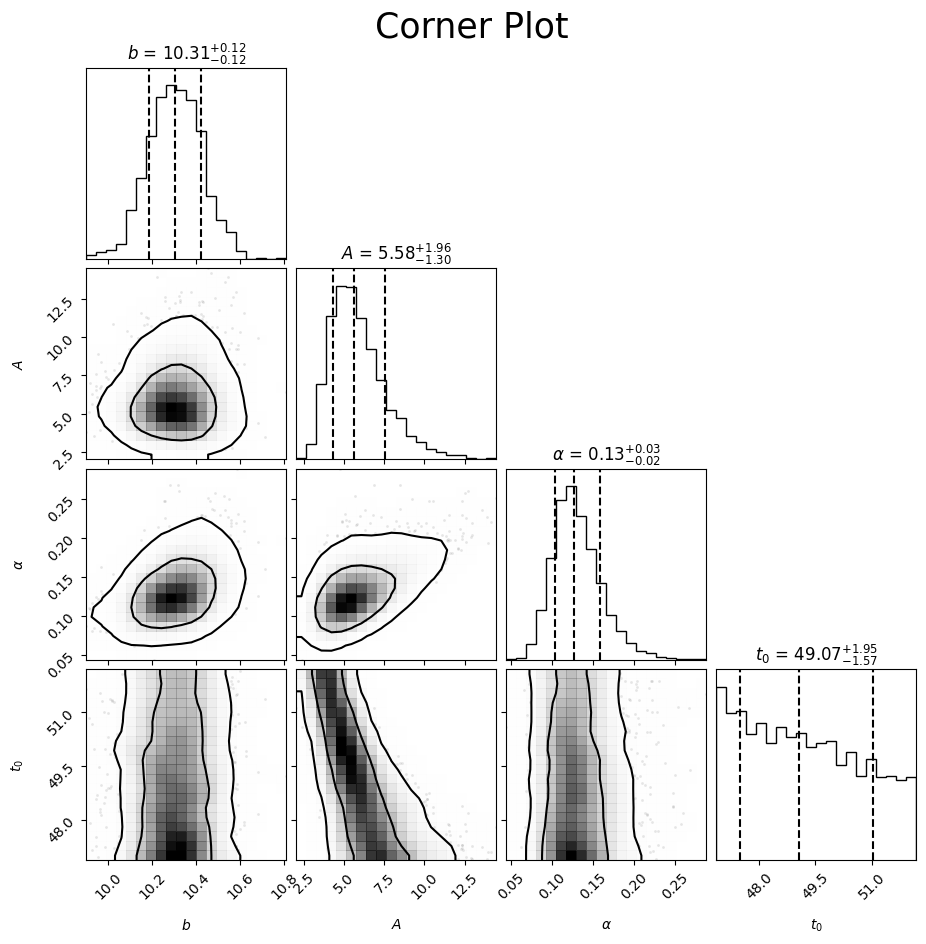

In [451]:
labels = [r'$b$', r'$A$', r'$\alpha$', r'$t_0$']

fig = corner.corner(samples, labels=labels,
                    quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, 
                    title_args={'fontsize': 12}, 
                    levels=(0.68, 0.95), 
                    smooth=1.0)

fig.suptitle("Corner Plot", fontsize = 25)
plt.subplots_adjust(top=0.92)  
plt.show()

There is a strong anti-correlation between $t_0$ and A. The model fit well both if $t_0$ is small and A is bigger, and if $t_0$ is big and A is smaller.

#### Parameter values and error estimation

In [453]:
percentiles_90 = [16, 84]
params = ['b', 'A', r'\alpha', 't_0']

for i, param in enumerate(params):
    param_samples = samples[:, i]
    median = np.median(param_samples)
    lower, upper = np.percentile(param_samples, percentiles_90)

    txt = r"\mathrm{{{0}}} = {1:.3f}_{{-{2:.3f}}}^{{+{3:.3f}}}".format(
        param, median, median-lower, upper-median
    )
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#### Posterior spread of model solution

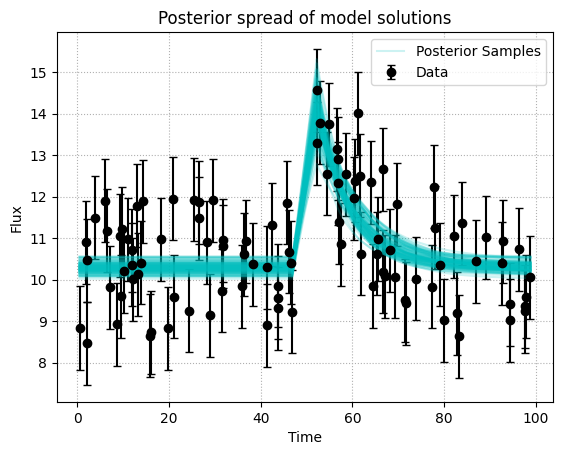

In [452]:
# Extract 100 random samples
posterior_samples = samples[np.random.choice(len(samples), size=100, replace=False)]

# Plot the data
plt.errorbar(t, flux, yerr=err_flux, fmt='o', color = 'k', capsize=3, label='Data')

# Plot the posterior for the sampled parameters
for i, (b, A, alpha, t_0) in enumerate(posterior_samples):
    label = "Posterior Samples" if i == 0 else None
    plt.plot(t, model(t, b, A, alpha, t_0), color='c', alpha=0.2, label=label)

plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Posterior spread of model solutions')
plt.legend()
plt.grid(linestyle=':')
plt.show()

## Part 2

8. Fit the same model from before with the same priors, but this time use nested sampling. 

    $y = b$, for $t < t_0$

    $y = b + A \exp[-\alpha (t - t_0)]$, for $t \geq t_0$ 

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used ppf from scipy.stats.uniform, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

9. Another possible model that may explain the data is a Gaussian profile described by:
    $y = b + A \exp[-(t - t_0)^2 / (2 \sigma_W^2)]$

    Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

10. Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data? Express this in terms of the Jeffrey's scale.

In [454]:
import dynesty

from dynesty import utils as dyfunc
from dynesty import plotting as dyplot

In [455]:
def prior_transform(params):
    params[0] = 50 * params[0]
    params[1] = 50 * params[1]
    params[2] = np.exp(10 * params[2] - 5)
    params[3] = 100 * params[3]
    return params

def log_likelihood(params):
    b, A, alpha, t0 = params
    model_flux = model(t, b, A, alpha, t0)
    return -0.5 * np.sum(((flux - model_flux) / err_flux)**2 + np.log(2 * np.pi * err_flux**2))


### Nested sampling

In [456]:
sampler = dynesty.NestedSampler(log_likelihood, prior_transform, ndim, nlive=1000, bootstrap=0)
sampler.run_nested()
sresults = sampler.results

/tmp/ipykernel_13222/2699962725.py:2: RuntimeWarning: overflow encountered in exp
  return np.where(t < t_0, b, b + A * np.exp(-alpha * (t - t_0)))
/tmp/ipykernel_13222/2699962725.py:2: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t_0, b, b + A * np.exp(-alpha * (t - t_0)))
3501it [00:18, 18.20it/s, bound: 1 | nc: 7 | ncall: 35033 | eff(%):  9.993 | loglstar:   -inf < -270.867 <    inf | logz: -278.974 +/-  0.085 | dlogz: 132.452 >  1.009]      /tmp/ipykernel_13222/2699962725.py:2: RuntimeWarning: overflow encountered in exp
  return np.where(t < t_0, b, b + A * np.exp(-alpha * (t - t_0)))
/tmp/ipykernel_13222/2699962725.py:2: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t_0, b, b + A * np.exp(-alpha * (t - t_0)))
/tmp/ipykernel_13222/2699962725.py:2: RuntimeWarning: overflow encountered in exp
  return np.where(t < t_0, b, b + A * np.exp(-alpha * (t - t_0)))
/tmp/ipykernel_13222/2699962725.py:2: RuntimeWarning: overflow encountered i

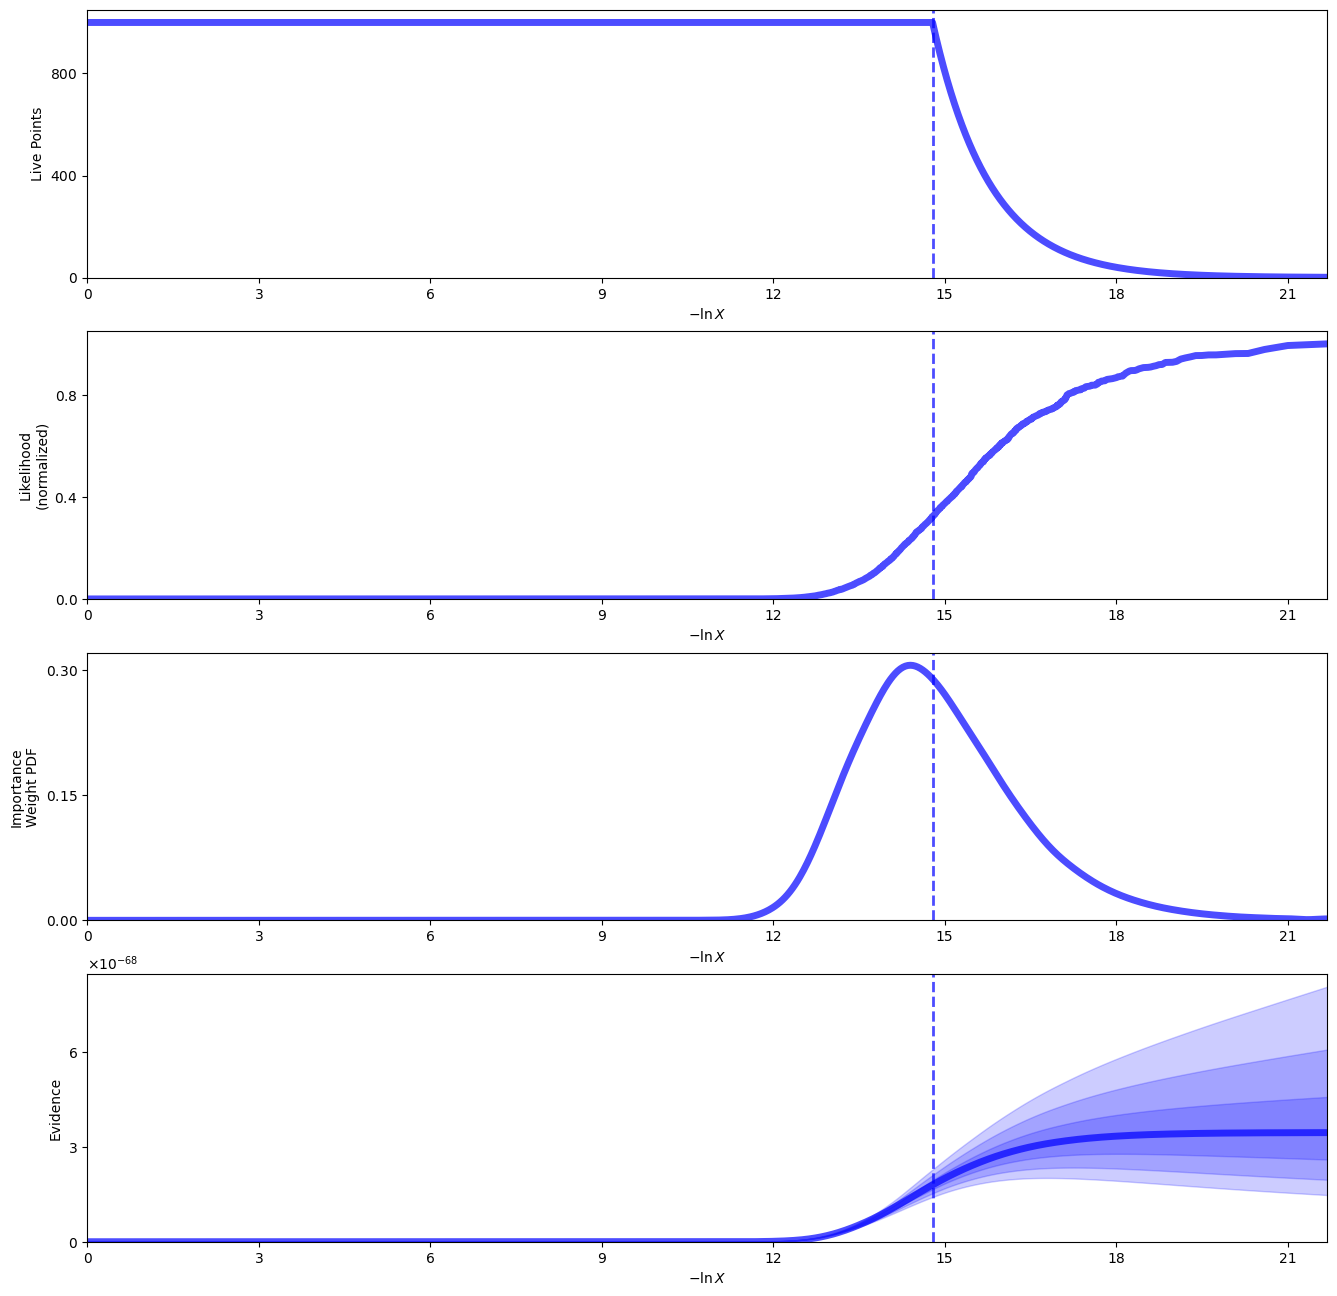

In [457]:
rfig, raxes = dyplot.runplot(sresults)

#### Trace plot

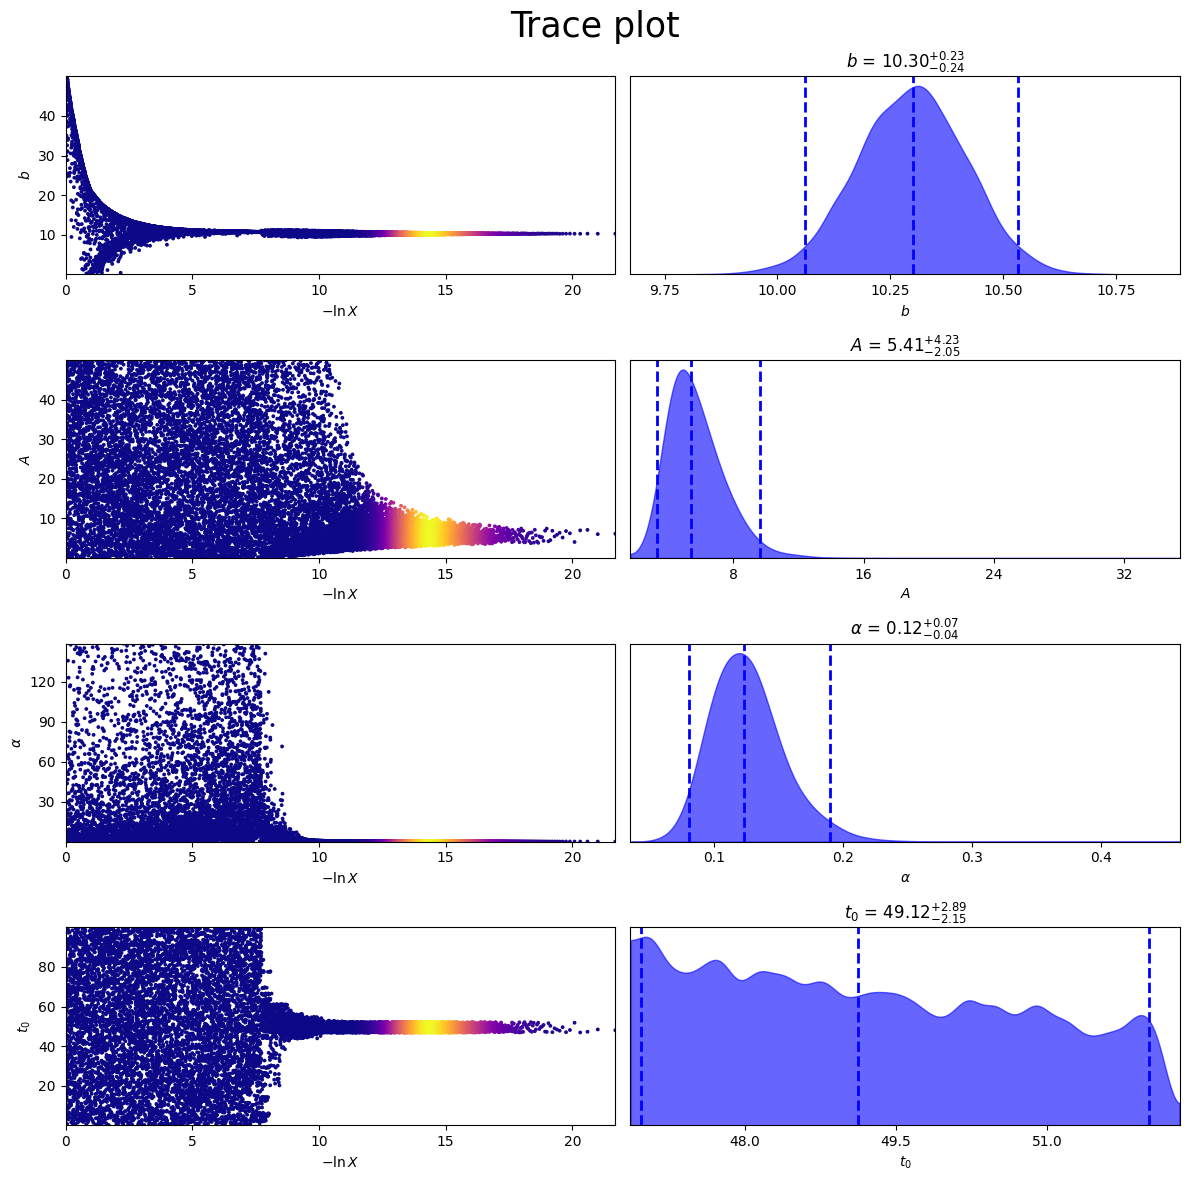

In [458]:
labels = [r'$b$', r'$A$', r'$\alpha$', r'$t_0$']

tfig, taxes = dyplot.traceplot(sresults,
                               labels=labels,
                               show_titles=True, 
                               title_fmt='.2f', 
                               title_kwargs={'fontsize': 12})

tfig.suptitle('Trace plot', fontsize=25)
tfig.tight_layout()

#### Corner plot

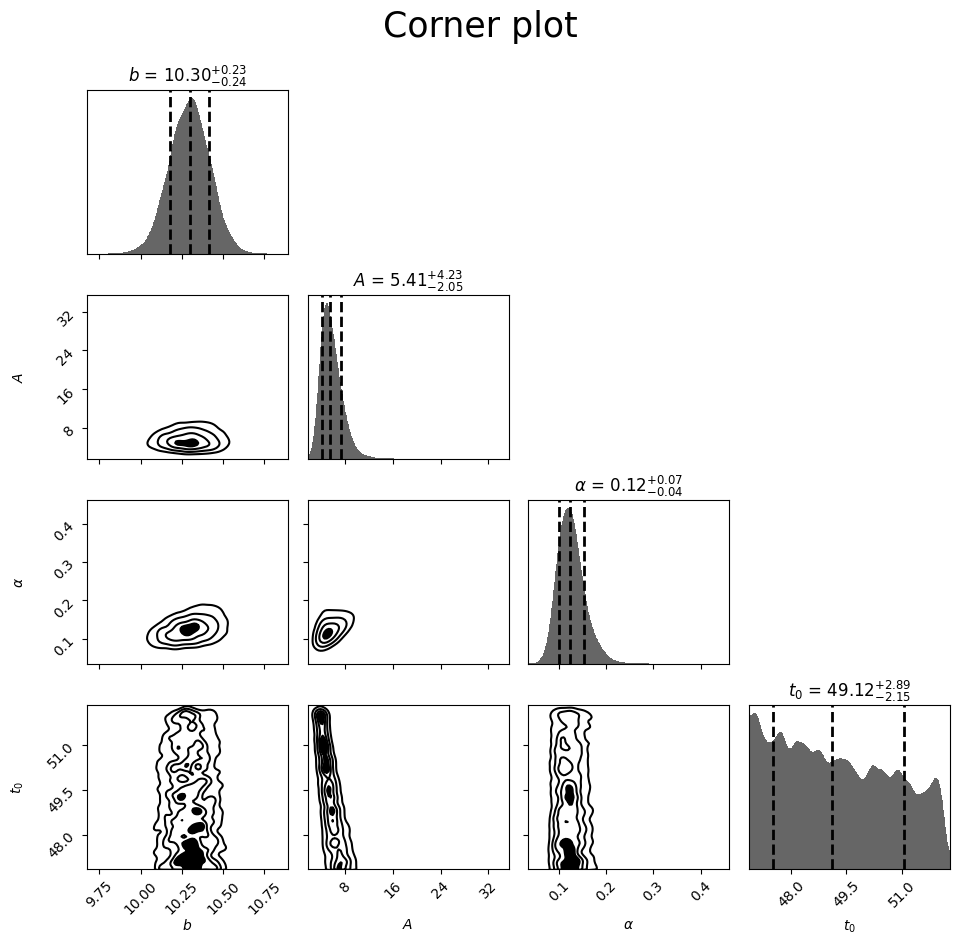

In [459]:
# Corner plot
labels = [r'$b$', r'$A$', r'$\alpha$', r'$t_0$']

fig = dyplot.cornerplot(sresults, labels=labels, 
                    quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, 
                    title_fmt='.2f', 
                    title_kwargs={'fontsize': 12})

plt.suptitle('Corner plot', fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

#### Parameter values and errors estimation

In [460]:
# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

evidence = sresults.logz[-1] #evidence
err_evidence = sresults.logzerr[-1]
print(f"Bayesian evidence: log Z = {evidence:.3f} ± {err_evidence:.3f}")

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.16, 0.5, 0.84], weights=weights)
             for samps in samples.T]

for param, q in zip(params, quantiles):
    median = q[1]
    lower = median - q[0]
    upper = q[2] - median
    txt = r"\mathrm{{{0}}} = {1:.3f}_{{-{2:.3f}}}^{{+{3:.3f}}}".format(param, median, lower, upper)
    display(Math(txt))


Bayesian evidence: log Z = -155.338 ± 0.283


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Gaussian model

In [461]:
def gauss_model(b, A, t0, sigma_w, t):
    return b + A * np.exp(-(t - t0)**2 / (2 * sigma_w**2))

def prior_transform_gauss(params):
    params[0] = 50 * params[0]
    params[1] = 50 * params[1]
    params[2] = 100 * params[2]
    log_sigma_w = -4 + 8 * params[3] 
    params[3] = np.exp(log_sigma_w)
    return params

def log_likelihood_gauss(params):
    b, A, t0, sigma_w = params
    flux_model = gauss_model(b, A, t0, sigma_w, t)
    chi2 = ((flux - flux_model) / err_flux)**2
    if np.any(chi2 > 1e15):
        return -np.inf
    return -0.5 * np.sum(np.log(2 * np.pi * err_flux**2) + chi2)


#### Nested sampling

In [ ]:
sampler_gauss = dynesty.NestedSampler(log_likelihood_gauss, prior_transform_gauss, ndim=ndim, bootstrap=0)
sampler_gauss.run_nested()
sresults_gauss = sampler_gauss.results

8509it [00:09, 928.82it/s, +500 | bound: 45 | nc: 1 | ncall: 53161 | eff(%): 17.108 | loglstar:   -inf < -144.333 <    inf | logz: -160.626 +/-  0.180 | dlogz:  0.001 >  0.509]


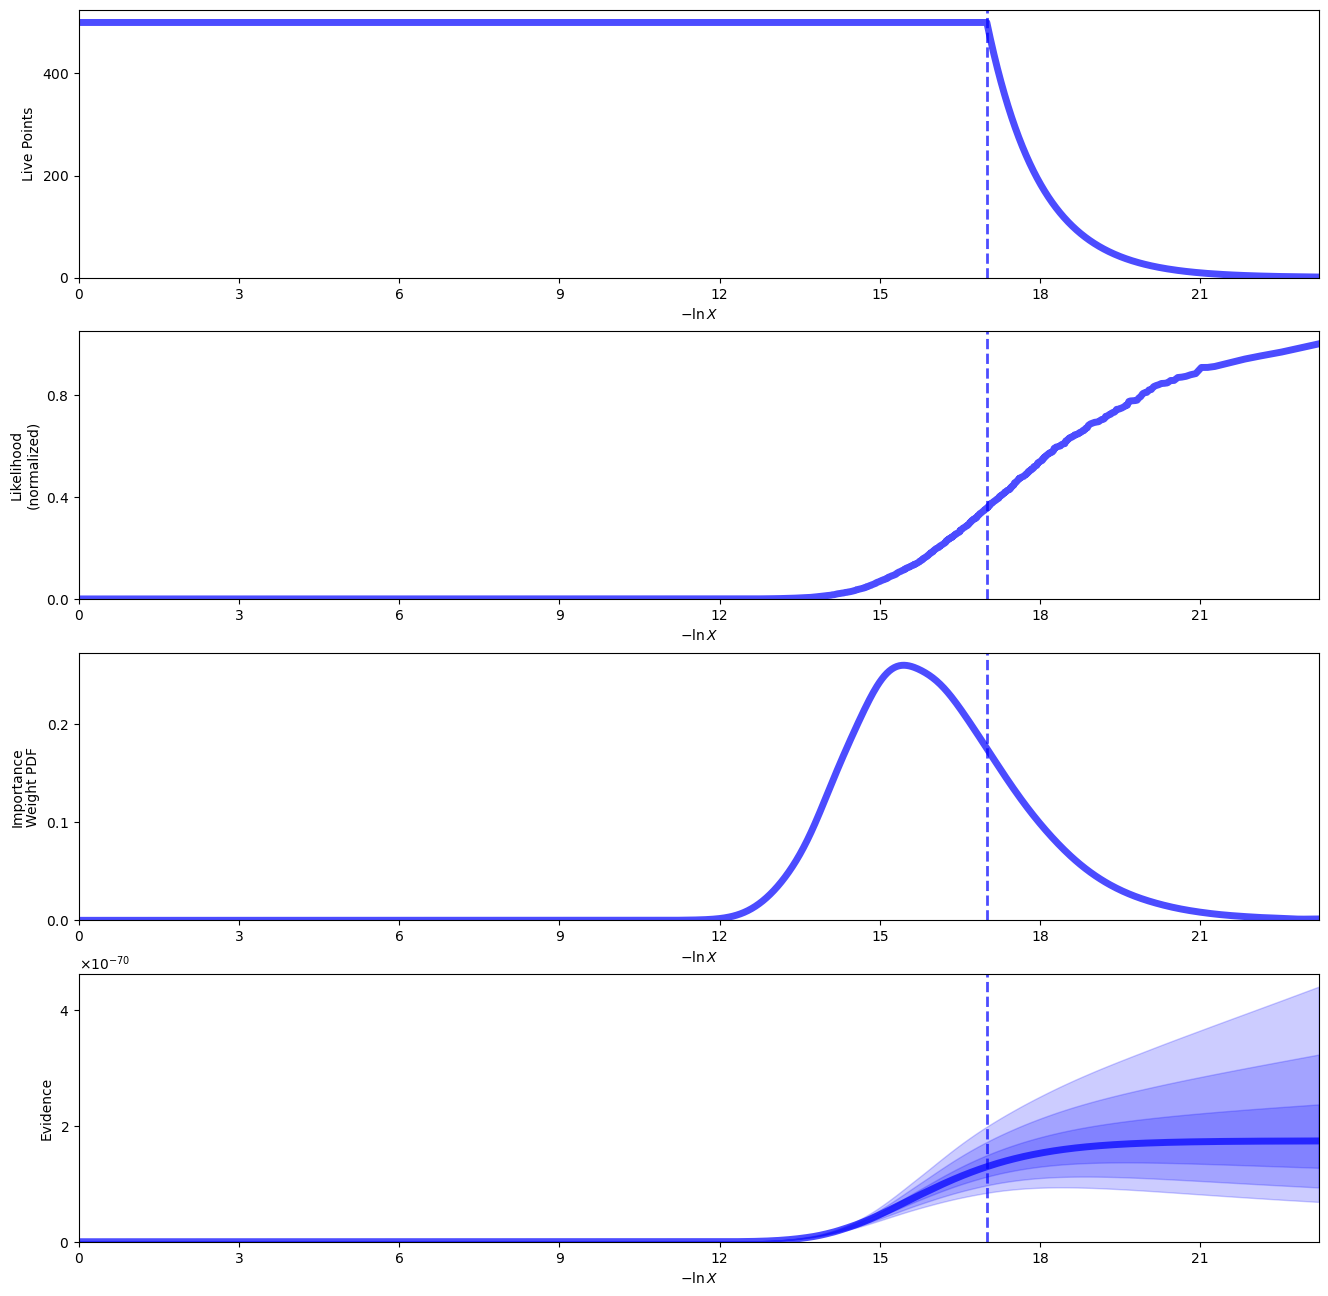

In [463]:
rfig, raxes = dyplot.runplot(sresults_gauss)

#### Trace plots

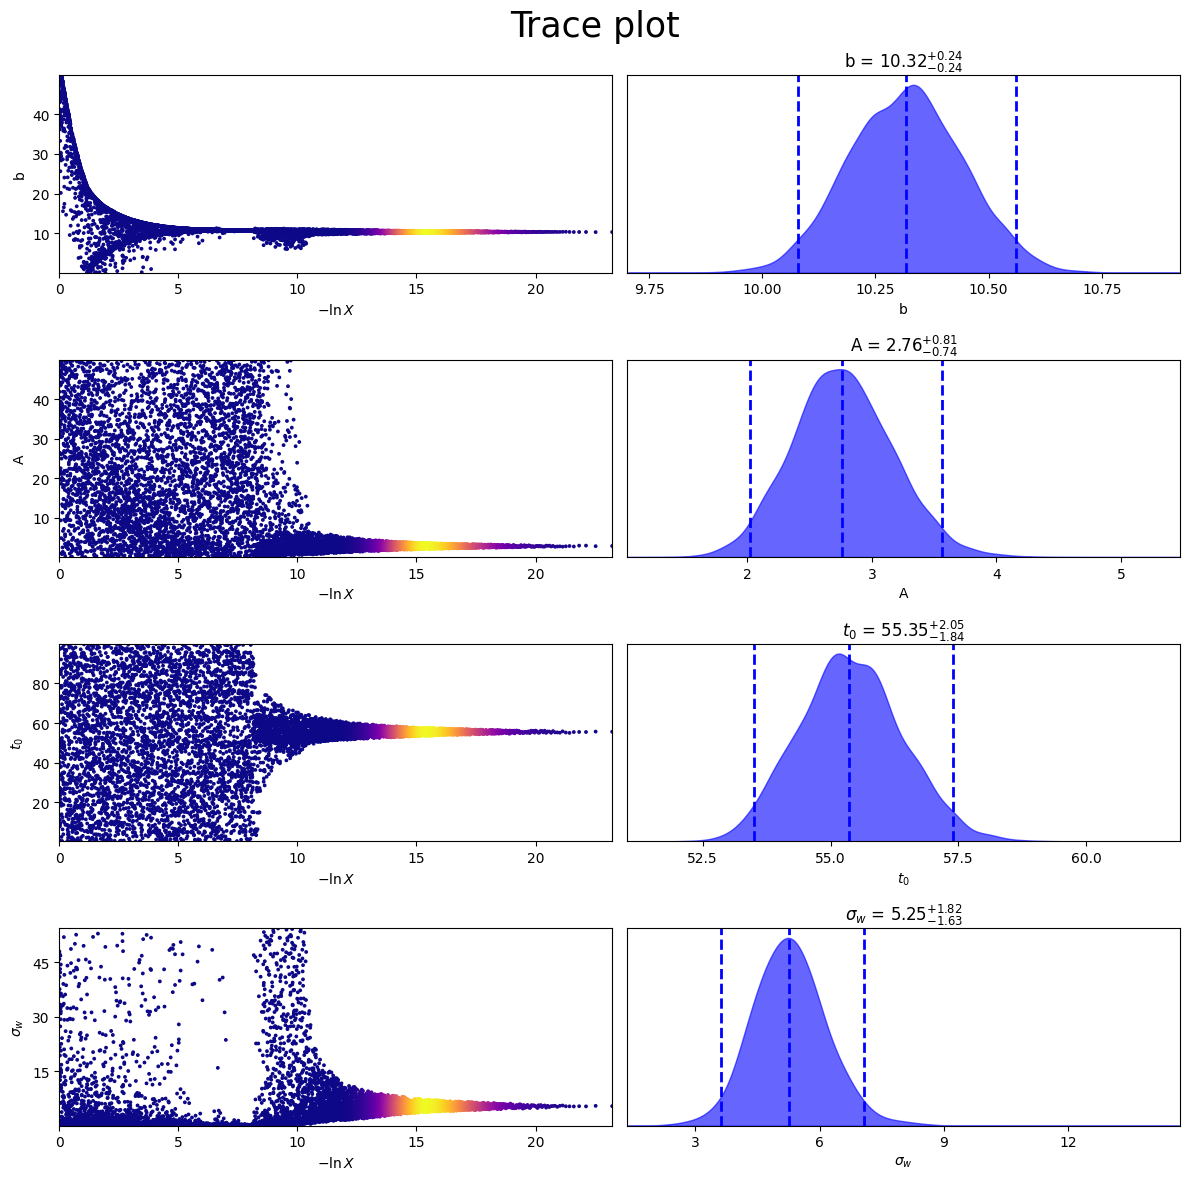

In [ ]:
labels = ['b', 'A', r'$t_0$', r'$\sigma_w$']

tfig, taxes = dyplot.traceplot(sresults_gauss,
                               labels=labels,
                               show_titles=True, 
                               title_fmt='.2f', 
                               title_kwargs={'fontsize': 12})

tfig.suptitle('Trace plot', fontsize=25)
tfig.tight_layout()

#### Corner plot

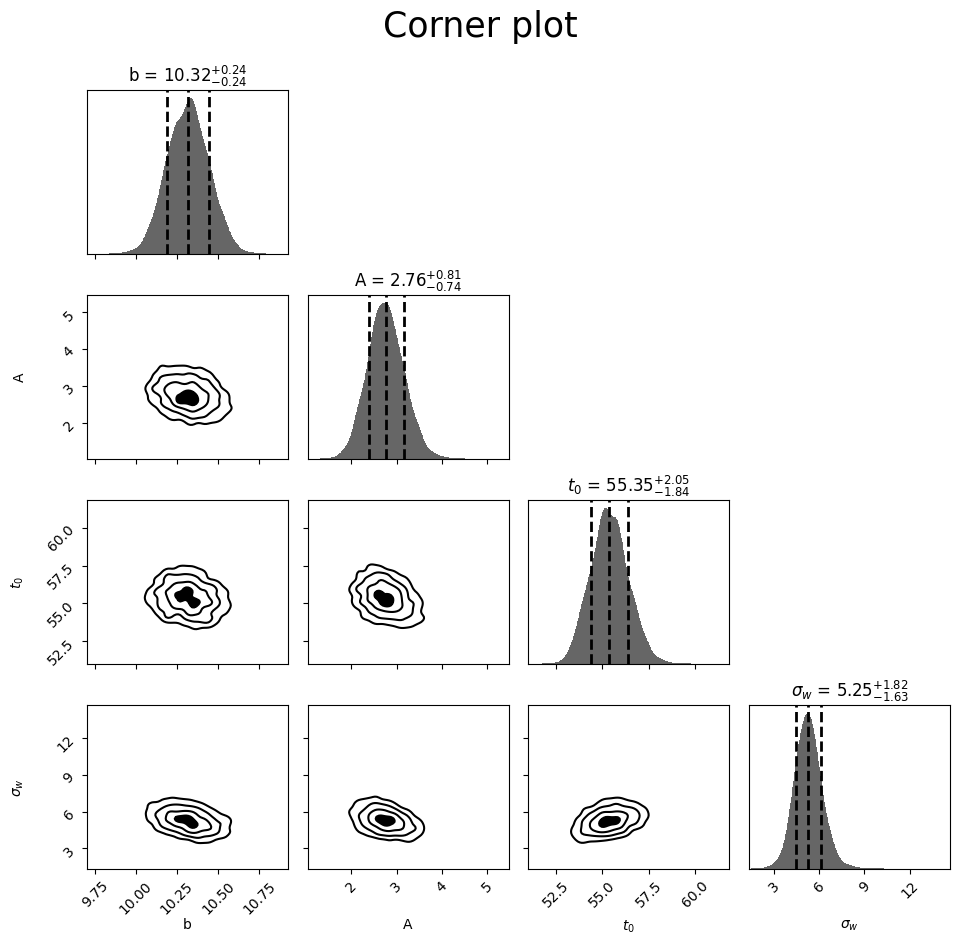

In [ ]:
labels = ['b', 'A', r'$t_0$', r'$\sigma_w$']

fig = dyplot.cornerplot(sresults_gauss, labels=labels, 
                    quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, 
                    title_fmt='.2f', 
                    title_kwargs={'fontsize': 12})

plt.suptitle('Corner plot', fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

#### Parameter values and error estimation

In [ ]:
posterior_gauss = sresults_gauss.samples  # samples
weights_gauss = np.exp(sresults_gauss.logwt - sresults_gauss.logz[-1])  # normalized weights

evidence_gauss = sresults_gauss.logz[-1] #evidence
err_evidence_gauss = sresults_gauss.logzerr[-1]
print(f"Bayesian evidence: log Z = {evidence_gauss:.3f} ± {err_evidence_gauss:.3f}")

param_names = ['b', 'A', r't_0', r'\sigma_w']

# Compute 16%-84% quantiles (approx 1-sigma)
quantiles_gauss = [dyfunc.quantile(samps, [0.16, 0.5, 0.84], weights=weights_gauss)
                   for samps in posterior_gauss.T]

for name, q in zip(param_names, quantiles_gauss):
    median = q[1]
    lower = median - q[0]
    upper = q[2] - median
    txt = r"\mathrm{{{0}}} = {1:.3f}_{{-{2:.3f}}}^{{+{3:.3f}}}".format(name, median, lower, upper)
    display(Math(txt))

Bayesian evidence: log Z = -160.626 ± 0.310


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#### Posterior spread of Gaussian model

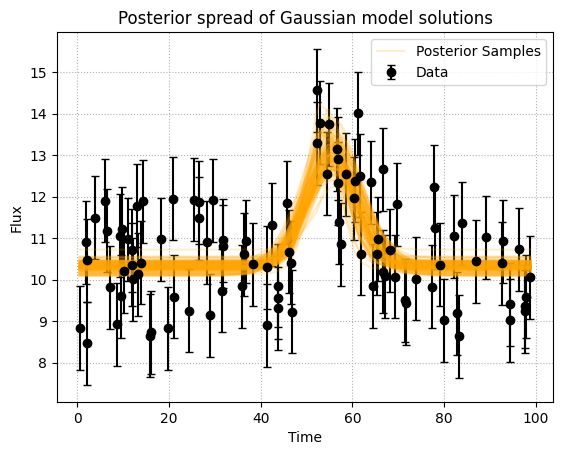

In [467]:
# Extract 100 random weighted samples
# Resample according to weights to get representative posterior
posterior_samples_gauss = posterior_gauss[np.random.choice(len(posterior_gauss), size=100, replace=False, p=weights_gauss/weights_gauss.sum())]

# Plot the data
plt.errorbar(t, flux, yerr=err_flux, fmt='o', color='k', capsize=3, label='Data')

# Plot the posterior for the sampled parameters
for i, (b, A, t0, sigma_w) in enumerate(posterior_samples_gauss):
    label = "Posterior Samples" if i == 0 else None
    plt.plot(t, gauss_model(b, A, t0, sigma_w, t), color='orange', alpha=0.2, label=label)

plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Posterior spread of Gaussian model solutions')
plt.legend()
plt.grid(linestyle=':')
plt.show()

### Model comparison: Burst vs. Gaussian

To compute the *Odds fraction* we use this formula:

$$O_{1,2} =  \cdot \frac{\Pi (\Theta_1)}{\Pi (\Theta_2)}$$

where $B_{1,2}$ is the Bayse factor, $\Pi (\Theta_1)$ and $\Pi (\Theta_2)$ are the prior knowledge I might have on the two models. This is important when we are mostly sure about one model with respect to the other, and we test them anyway to see if model 2 provides as well a good description of data. I don't know much about the underlying process of data acquiring nor the physics beyond this type of event, so I chose to keep the prior fraction $= 1$. This way, the evidence ratio only (Bayes factor) will provide the hint on the best model.

In [468]:
def interpret_bayes_factor(B):
    if 0 <= B < 1/2:
        return "Barely worth mentioning for Model 1"
    elif 1/2 <= B < 1:
        return "Substantial evidence for Model 1"
    elif 1 <= B < 3/2:
        return "Strong evidence for Model 1"
    elif 3/2 <= B < 2:
        return "Very strong evidence for Model 1"
    elif 2 <= B:
        return "Decisive evidence for Model 1"

In [ ]:
B_12 = np.exp(evidence) / np.exp(evidence_gauss) # Burst / Gaussian
print(f"Bayesian factor: ", B_12)

interpretation = interpret_bayes_factor(np.log10(B_12))
print(f"Interpretation according to Jeffreys' scale: {interpretation}")

Bayesian factor:  197.97953112386105
Interpretation according to Jeffreys' scale: Decisive evidence for Model 1


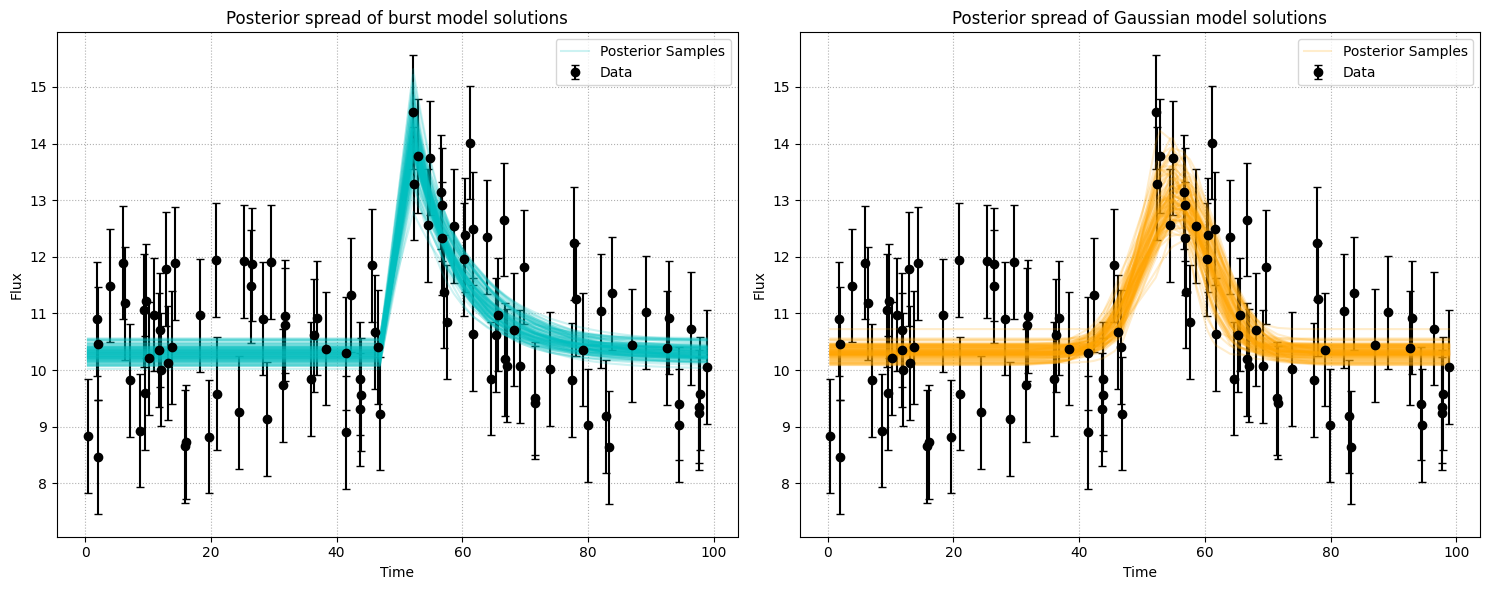

In [471]:
# Comparison of posterior spread solution of two models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Burst model
ax1.errorbar(t, flux, yerr=err_flux, fmt='o', color='k', capsize=3, label='Data')

for i, (b, A, alpha, t_0) in enumerate(posterior_samples):
    label = "Posterior Samples" if i == 0 else None
    ax1.plot(t, model(t, b, A, alpha, t_0), color='c', alpha=0.2, label=label)

ax1.set_xlabel('Time')
ax1.set_ylabel('Flux')
ax1.set_title('Posterior spread of burst model solutions')
ax1.legend()
ax1.grid(linestyle=':')

# Gaussian model
ax2.errorbar(t, flux, yerr=err_flux, fmt='o', color='k', capsize=3, label='Data')

for i, (b, A, t0, sigma_w) in enumerate(posterior_samples_gauss):
    label = "Posterior Samples" if i == 0 else None
    ax2.plot(t, gauss_model(b, A, t0, sigma_w, t), color='orange', alpha=0.2, label=label)

ax2.set_xlabel('Time')
ax2.set_ylabel('Flux')
ax2.set_title('Posterior spread of Gaussian model solutions')
ax2.legend()
ax2.grid(linestyle=':')

plt.tight_layout()
plt.show()
